# Introduction to SoS notebook

Script of Scripts (SoS) is a workflow engine that allows you to create and execute workflows that consist of scripts in different languages. You can use sos as a notebook tool to execute scripts interactively, or as a workflow tool to execute workflows in batch mode under different environments. This introduction demonstrates the first method of using SoS.

## Starting SoS notebook

If you have Python 3 (>=3.4.0) installed, installation of SoS can usually be done using command

```
% pip3 install sos
```
or

```
% pip install sos
```
depending on your system configuration. This command will also install Jupyter notebook and the SoS kernel for Jupyter.

After installation you can check if you have everything ready by running command

In [1]:
run:
   jupyter kernelspec list

Available kernels:
  python3    /Users/bpeng1/bin/anaconda/lib/python3.5/site-packages/ipykernel/resources
  ir         /Users/bpeng1/Library/Jupyter/kernels/ir
  sos        /usr/local/share/jupyter/kernels/sos


Here I am using SoS to run the shell command with a `run` action but you should see similar output if you enter the command from a terminal. If the command runs and outputs a kernel named `sos`, you can start Jupyter notebook using command

```
% jupyter notebook
```
and select `SoS` when you start a new notebook. Note that you will need to install the [IRkernel](https://github.com/IRkernel/IRkernel) if you would like to use R in SoS notebooks.

## Basic SoS

SoS is based on a slightly modified Python 3 syntax, with two syntax differences. The first one is that all single-triple quote strings are raw strings. That it to say, if you use `\n` in a triple-quote string, you will get the raw string as follows,

In [2]:
myscript = '''
this is my string with \n
'''
myscript

'\nthis is my string with \\n\n'

In comparison, if you define such a string in pure python, `\n` will be interpretted as newline.

In [3]:
python:
myscript = '''
this is my string with \n
'''
print(repr(myscript))

'\nthis is my string with \n\n'


Another difference is that SoS treats all strings as format string with string interpolation. Using the default sigil `${ }`, all variables and expressions between `${` and `}` will be evaluated and replaced with their values. The complete rules are defined in the [SoS documentation](https://github.com/BoPeng/SOS/wiki/Documentation#string-interpolation) but here are some examples:

In [4]:
resource   = '~/resources'
ref_genome = '${resource}/ref_genome/hg19'
samples    = ['sampleA', 'sampleB', 'sampleC']
'There are ${len(samples)} samples with names ${samples!,}.'

'There are 3 samples with names sampleA, sampleB, sampleC.'

Here the variables are all stored in a SoS dictionary. You can print values of individual variables using 

In [5]:
ref_genome

'~/resources/ref_genome/hg19'

or using a SoS magic `%dict` to check the content of this dictionary.

In [6]:
%dict keys

{'samples', '_index', 'step_name', 'CONFIG', 'myscript', 'resource', 'ref_genome'}

These are the variables that can be used in the notebook to, for example, compose scripts in other langauges. For example, you can call a shell command with variable `ref_genome`

In [7]:
run:
    echo ${ref_genome!e}

/Users/bpeng1/resources/ref_genome/hg19


Here we used variable `ref_genome` with convertion `e` (`os.path.expanduser`) to create a script and use `bash` to execute it.

## Using other languages


There are two ways to use other languages in SoS.

1. **Create scripts and use SoS to execute them** as you have seen for cells that start with `run:` and `python:`. This method requires the availability of the underlying interpreter (`bash`, `python`, `R` etc) but not corresponding Jupyter kernels. The scripts must be complete in this case.

2. **Start separate kernels using SoS magics `%with` and `%use` **. The `%with` magic allows you to execute a cell in a separate kernel, and `%use` magic allows you to switch to another kenel until you switch back. The scripts and commands will be executed in the kernels interactively and have access to variables in previous runs.

In [8]:
%with R
numbers = rnorm(5)
numbers

[1]  0.08568303 -0.76076156 -0.85481354 -1.47211161 -0.74582242

SoS will switch back to the SoS kernel after the evaluation. It is also worth noting that the communication is one-directional in that whereas the scripts can be created using SoS variables, SoS does not collect any result from another kernel (to which SoS knows nothing). For example, the `numbers` variable in the IR kernel is unknown to SoS:

In [9]:
numbers

SoS workflow contains errors: default
[numbers ] NameError:
	name 'numbers' is not defined

Now, if you have a long script that you would like to debug line by line, you can switch to another kernel and switch back until you are done:

In [10]:
%use R

In [11]:
numbers

[1]  0.08568303 -0.76076156 -0.85481354 -1.47211161 -0.74582242

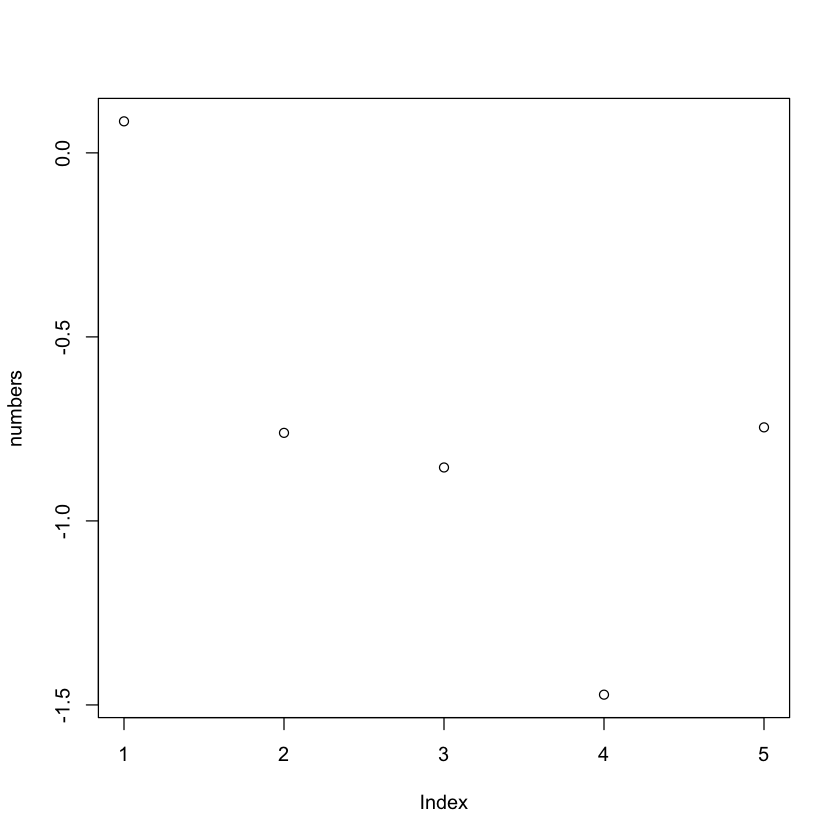

In [12]:
plot(numbers)

In [13]:
%use sos
# this magic switch the notebook back to SoS kernel

## SoS steps

In addition to variable definitions and execution of scripts, notebook cells can contain arbitrary SoS statements and steps. This section demonstrates some of the features that are most useful for interactive use. Please refer to the [SoS documentation](https://github.com/BoPeng/SOS/wiki/Documentation) for a complete reference.

First, you can specify one or more output files in each step. Other than using variables `_output` and `output` for the script, SOS can preview the output files for most file types.

input: 
output: test.jpg


> test.jpg (24.4 KB)

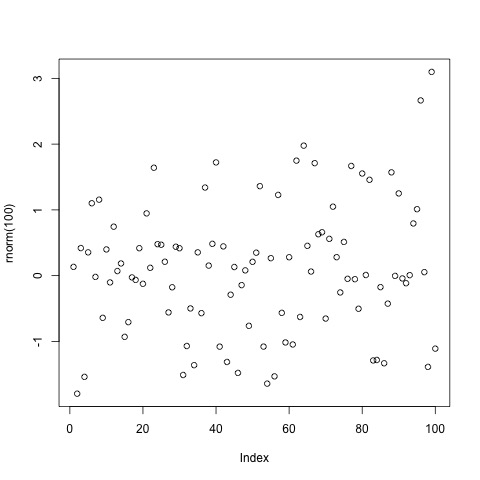

In [14]:
output: 'test.jpg'
R:
    jpeg('${output}')
    plot(rnorm(100))
    dev.off()

The `%set` magic can be used to set SoS options such as verbosity (`-v`), tracribe (`-t`), prepare mode (`-p`). For example, the following example turns on logging and transcription mode so that SoS prints out step input, output, and a copy of the script executed. The options are useful for debugging and you can turn them off using `%set` (set option to empty string).

In [15]:
%set -v2 -t
input: '*.sos', group_by='single'
run:
    echo Processing  ${_input}

Processing rnaseq_tutorial.sos


INFO: Execute default_0: 
INFO: input:   ['rnaseq_tutorial.sos']
/bin/bash:
    echo Processing  rnaseq_tutorial.sos


input: rnaseq_tutorial.sos 
output:

## Reports

The markdown cells of Jupyter notebook are static report because they do not interact with SoS. If you would like to display reports in markdown format, with string interpolation, you can use the SoS report lines (lines start with `! `) and `report` action, as demonstrated in the following cells. 

In [16]:
! This expriment has ${len(samples)} samples with names ${samples!,}

This expriment has 3 samples with names sampleA, sampleB, sampleC

In [17]:
report:
  ### sample description
  This experiment has ${len(samples)} samples with names ${samples!,}

### sample description
This experiment has 3 samples with names sampleA, sampleB, sampleC

## Convert SoS notebooks to real SoS workflows

The SoS notebooks are good for interactive data analysis, but not for the execution of large workflows. There are also major differences on how SoS steps are executed in Jupyter notebook and in batch mode. More specifically,

1. Steps should be put after section headers with logical order of execution.
2. Scripts are executed as complete scripts so they have to be complete/self-contained.
3. Variables in steps are global in interactive mode but are private in batch mode.

If you would like to convert your notebook to a workflow, you will need to

1. Remove all %magics from the notebook because these are not understood by SoS
2. Convert the notebook from `.ipynb` format to `.sos` format by `File`->`Download as`->`SoS (.sos)`, or by running command 

    ```
    sos convert mynote.ipynb --sos mynote.sos
    ```
3. Edit the resulting `.sos` file to add appropriate section head and test it using `sos` command.